# Downloading, Filtering, Processing and Analysing Google Ngrams Fr-2012 for High Degree Prefixes Analaysis



# A. Downloading / filtering google ngrams files

to download google ngrams data, we provide two shell scripts :
- `retrieve_googlengrams.fr.2012.sh` : this program download all necessary files with curl; files are stored in the `../data_ngram/googlengrams.fr.2012` subdirectory and then generate for each file a csv file (`<name_of_gz_file>.gz.cleaned.csv`) containing just the lines beginning with one of the prefix, containing concerned year and no POS tag (with _);
- `retrieve_googlengrams.fr.2020.sh`: the same with Google Ngrams version 2020 (stored in `../data_ngram/googlengrams.fr.2020`); as this version is not yet documented, we do not use it at the moment;

# B. Filter and generate merged 1-,2- and 3-grams files : 

- normalize strings : lowercase(), and convert `\s+--?\s+` to ' -'; 
- Check form of string (see regexp for query1gram, query2ram and query3gram) and drop string with integers;
- merge rows with same string values (after lowercase and normalization of `-`) : figures are the sum of respective values for given year;
- save skipped rows for each file for checking errors of parsing;
- merge all 1-grams, all 2-grams and all 3-grams data;
- save results in `../data/`: `fre.2012.prefixes.1.grams.1799-2009.csv`, `fre.2012.prefixes.2.grams.1799-2009.csv`,,`fre.2012.prefixes.3.grams.1799-2009.csv` 


In [91]:
import requests
import sys, csv,re, random, glob,os
import gzip
import pandas as pd



def read_google_ngram_to_df(filename, mindate=1799, daterange="1799-2009",query='.+'):
    ''' get google ngrams retrieved cleaned files and store into df
    format : ngram TAB year TAB match_count TAB volume_count NEWLINE
    '''
    data_columns = ['string', 'year', 'total_count','total_doc']   
    df1= pd.read_csv(filename, names = data_columns, usecols=['string', 'year', 'total_count'], sep='\t', error_bad_lines=True)
    # convert string to lower
    df1['string'] = df1.string.str.lower()  
    # convert '\s+--?\s+' to ' - '
    df1['string'] = df1.string.str.replace('\s+--?\s+', ' - ', regex=True)
    print("Initial df : ",df1.shape)
    # keep track of skipped lines to check
    dfbk = df1[(~df1['string'].str.contains(query, case=False)) | (df1.string.str.contains('\d'))]
    dfbk.to_csv(filename + '.skippedLines.csv',index=False)
    # just keep lines with string corresponding to query and without digit and with year > 1799
    df2 = df1[(df1['string'].str.contains(query, case=False)) & (~df1.string.str.contains('\d')) & (df1.year > 1799)]
    print("After string regex check : ", df2.shape)
    
    # merge identical string-year rows
    df3 = df2.groupby(['string','year'])['total_count'].sum().reset_index()
    print("After merging strings : ", df3.shape)

    # pivot the data so as to have years as columns and string (ngram) as row index
    df4 = df3.pivot_table(values='total_count', index='string', columns='year', fill_value=0) # index='string', aggfunc='mean'
    return df4

In [92]:


# main 

# synt : processing synthesis
synth={}

prefixes = ('archi','extra','hyper','hypra','maxi','méga','super','ultra')
mindate = 1799
maxdate = 2009
query1gram =  '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\w{2,}$'
query2gram =  '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s\w{2,}$'
query3gram =  '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+--?\s+\w{2,}$'
query_type='prefixes'
lang='fre'
str_range = str(mindate) + "-" + str(maxdate)
input_path = '../data_ngrams/googlengrams.fr.2012/'
output_path = '../data/'

# read google ngrams files downloaded beforehand and merge them
# 1-grams
files1 = glob.glob(input_path + 'googlebooks-fre-all-1gram*.cleaned.csv')
res = []
for f in files1:
    print("parsing " +  f )
    df = read_google_ngram_to_df(f,mindate=1799,daterange=str_range, query=query1gram)
    res.append(df)
# merge dataframes
df1 = pd.concat(res)
print("Final df : ",df1.shape)
synth['1grams']= df1.shape[0]
df1.to_csv( output_path + 'fre.2012.prefixes.1.grams.' + str_range + ".before_stoplists.csv")
print("***"*20)

# 2-grams
files2 = glob.glob(input_path + 'googlebooks-fre-all-2gram*.cleaned.csv')
res = []
for f in files2:
    print("parsing " +f )
    df = read_google_ngram_to_df(f,mindate=1799,daterange=str_range, query=query2gram)
    res.append(df)
# merge dataframes
df1 = pd.concat(res)
print("Final df : ",df1.shape)
synth['2grams']= df1.shape[0]
df1.to_csv( output_path + 'fre.2012.prefixes.2.grams.' + str_range + ".before_stoplists.csv")
print("***"*20)

# 3-grams
files3 = glob.glob(input_path + 'googlebooks-fre-all-3gram*.cleaned.csv')
res = []
for f in files3:
    print("parsing " + f )
    df = read_google_ngram_to_df(f,mindate=1799,daterange=str_range, query=query3gram)
    res.append(df)
# merge dataframes
df1 = pd.concat(res)
print("Final df : ",df1.shape)
synth['3grams']= df1.shape[0]

df1.to_csv( output_path + 'fre.2012.prefixes.3.grams.' + str_range + ".before_stoplists.csv")
print(synth)

parsing ../data_ngrams/googlengrams.fr.2012/googlebooks-fre-all-1gram-20120701-a.gz.cleaned.csv
Initial df :  (111452, 3)
After string regex check :  (102928, 3)
After merging strings :  (76903, 3)
parsing ../data_ngrams/googlengrams.fr.2012/googlebooks-fre-all-1gram-20120701-e.gz.cleaned.csv
Initial df :  (113784, 3)
After string regex check :  (107481, 3)
After merging strings :  (91459, 3)
parsing ../data_ngrams/googlengrams.fr.2012/googlebooks-fre-all-1gram-20120701-h.gz.cleaned.csv
Initial df :  (107102, 3)
After string regex check :  (105591, 3)
After merging strings :  (92278, 3)
parsing ../data_ngrams/googlengrams.fr.2012/googlebooks-fre-all-1gram-20120701-m.gz.cleaned.csv
Initial df :  (69027, 3)
After string regex check :  (64625, 3)
After merging strings :  (51289, 3)
parsing ../data_ngrams/googlengrams.fr.2012/googlebooks-fre-all-1gram-20120701-s.gz.cleaned.csv
Initial df :  (169370, 3)
After string regex check :  (162455, 3)
After merging strings :  (137136, 3)
parsing ../

# C. Filter with stoplists

In [93]:
stoplist1gram={}
stoplist2gram={}
stoplist3gram={}
# load 1-, 2- and 3-grams separately

with open('../data/stoplists/stopwords_1grams.txt', mode="r",encoding='utf-8') as fin:
    for line in fin:
        if len(line.strip())>0:
            stoplist1gram[line.strip()]=1
with open('../data/stoplists/stopwords_2grams.txt', mode="r",encoding='utf-8') as fin:
    for line in fin:
        if len(line.strip())>0:
            stoplist2gram[line.strip()]=1
with open('../data/stoplists/stopwords_3grams.txt', mode="r",encoding='utf-8') as fin:
    for line in fin:
        if len(line.strip())>0:
            stoplist3gram[line.strip()]=1


print("Stoplist 1gram chargée : " + str(len(stoplist1gram.keys())) + " mots.")
print("Stoplist 2gram chargée : " + str(len(stoplist2gram.keys())) + " mots.")
print("Stoplist 3gram chargée : " + str(len(stoplist3gram.keys())) + " mots.")
total = len(stoplist1gram.keys()) + len(stoplist2gram.keys()) + len(stoplist3gram.keys())
print("Total Stoplists : " + str(total) + " mots.")



Stoplist 1gram chargée : 3923 mots.
Stoplist 2gram chargée : 1950 mots.
Stoplist 3gram chargée : 99 mots.
Total Stoplists : 5972 mots.


# Traitement des 1-grams

In [94]:

if os.path.isfile('../data/fre.2012.prefixes.1.grams.1799-2009.csv'):
    print("Loading the 1 gram big file (no pos)...")
    df= pd.read_csv('../data/fre.2012.prefixes.1.grams.1799-2009.csv', header=0, sep=',', error_bad_lines=True)#, index_col=0 
else:
    print("Please generate fre.2012.prefixes.1.grams.1799-2009.csv with previous cells")
    exit()
print(df.info())



# difference stoplist / 1grams 
df2 = df[df.string.isin(stoplist1gram)] 
print(len(df['string'].unique()))
listdf = df2['string'].unique()
res = set(stoplist1gram.keys()) - set(listdf)
print(len(res),res)



#
# élimination stoplist
df = df[~df.string.isin(stoplist1gram)] # elimination mots dans les stoplists

print(df.info())
# generate prefix, word and sep columns 
pref_re = '^(ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)(?:.*)$'
pref_re2 = '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)(.*)$'
df['prefix'] = df.string.str.extract(pref_re, expand=True)
df['word'] = df.string.str.extract(pref_re2, expand=True)
df['sep'] = 'FUSION'
print(df.info())
synth['1gram_after_stoplist']= df.shape[0]
#print(df.head())
print(df.info())
print(df.prefix.value_counts())

Loading the 1 gram big file (no pos)...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7356 entries, 0 to 7355
Columns: 211 entries, string to 2009
dtypes: int64(210), object(1)
memory usage: 11.8+ MB
None
7356
0 set()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3433 entries, 0 to 7355
Columns: 211 entries, string to 2009
dtypes: int64(210), object(1)
memory usage: 5.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3433 entries, 0 to 7355
Columns: 214 entries, string to sep
dtypes: int64(210), object(4)
memory usage: 5.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3433 entries, 0 to 7355
Columns: 214 entries, string to sep
dtypes: int64(210), object(4)
memory usage: 5.6+ MB
None
hyper    1301
super     576
extra     559
supra     341
ultra     298
archi     182
méga      172
maxi        4
Name: prefix, dtype: int64


In [95]:
columns = df.columns
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df['full_count'] = df.apply(lambda x: x[periods].sum(), axis=1)
df.head()
df.to_csv("../data/df_prefixes_1grams.2012_after_stoplist.csv", index=False)

# 2-grams processing

In [96]:

if os.path.isfile('../data/fre.2012.prefixes.2.grams.1799-2009.csv'):
    print("Loading the 2 gram big file (no pos)...")
    df2= pd.read_csv('../data/fre.2012.prefixes.2.grams.1799-2009.csv', header=0, sep=',', error_bad_lines=False)#, index_col=0 
else:
    print("Please first launch retrieve_google_2grams.py to generate fre.2012.prefixes.2.grams.1799-2009.csv")
    exit()

print(df2.info())

# difference stoplist / 2grams 
df3 = df2[df2.string.isin(stoplist2gram)] # stoplist
print(len(df3['string'].unique()))
listdf = df3['string'].unique()
res = set(stoplist2gram.keys()) - set(listdf)
print(len(res),res)




# élimination stoplist
df2 = df2[~df2.string.isin(stoplist2gram)]
df2.info()
df2.head()

# colonnes préfix et word
pref_re = '^(ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+(?:\w{2,})$'
pref_re2 = '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+(\w{2,})$'
df2['prefix'] = df2.string.str.extract(pref_re, expand=True)
df2['word'] = df2.string.str.extract(pref_re2, expand=True)
df2['sep'] = 'ESPACE'
print(df2.info())
synth['2gram_after_stoplist']= df2.shape[0]

print(df2.prefix.value_counts())


Loading the 2 gram big file (no pos)...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Columns: 211 entries, string to 2009
dtypes: float64(124), int64(86), object(1)
memory usage: 4.2+ MB
None
1950
0 set()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 1 to 2574
Columns: 211 entries, string to 2009
dtypes: float64(124), int64(86), object(1)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 1 to 2574
Columns: 214 entries, string to sep
dtypes: float64(124), int64(86), object(4)
memory usage: 1.0+ MB
None
extra    177
super    169
ultra    147
hyper     60
supra     59
archi     11
méga       4
maxi       2
Name: prefix, dtype: int64


In [97]:
columns = df2.columns
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df2['full_count'] = df2.apply(lambda x: x[periods].sum(), axis=1)
df2.head()
df2.to_csv("../data/df_prefixes_2grams.2012_after_stoplist.csv", index=False)

# 3-grams processing

In [98]:

if os.path.isfile('../data/fre.2012.prefixes.3.grams.1799-2009.csv'):
    print("Loading the 3 gram big file (no pos)...")
    df3= pd.read_csv('../data/fre.2012.prefixes.3.grams.1799-2009.csv', header=0, sep=',', error_bad_lines=False)#, index_col=0 
else:
    print("Please first launch retrieve_google_3grams.py to generate fre.2012.prefixes.3.grams.1799-2009.csv")
    exit()
print(df3.info())

# difference stoplist / 1grams 
df4 = df3[df3.string.isin(stoplist3gram)] 
print(len(df4['string'].unique()))
listdf = df4['string'].unique()
res = set(stoplist3gram) - set(listdf)
print(len(res),res)

# élimination stoplist
df3 = df3[~df3.string.isin(stoplist3gram)]
df3.info()

# colonnes préfix et word
pref_re = '^(ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+(?:--?)\s+(?:.*)$'
pref_re2 = '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+(?:--?)\s+(.*)$'
df3['prefix'] = df3.string.str.extract(pref_re, expand=True)
df3['word'] = df3.string.str.extract(pref_re2, expand=True)
df3['sep'] = 'TIRET'
print(df3.info())
synth['3gram_after_stoplist']= df.shape[0]

print(df3.prefix.value_counts())
#print(df3.head())

Loading the 3 gram big file (no pos)...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Columns: 211 entries, string to 2009
dtypes: float64(97), int64(113), object(1)
memory usage: 4.0+ MB
None
98
1 {'supra - ouultracide'}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2365 entries, 0 to 2462
Columns: 211 entries, string to 2009
dtypes: float64(97), int64(113), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2365 entries, 0 to 2462
Columns: 214 entries, string to sep
dtypes: float64(97), int64(113), object(4)
memory usage: 3.9+ MB
None
extra    817
ultra    552
super    381
supra    308
hyper    180
archi     94
méga      27
maxi       6
Name: prefix, dtype: int64


In [99]:
columns = df3.columns
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df3['full_count'] = df3.apply(lambda x: x[periods].sum(), axis=1)
df3.head()
df3.to_csv("../data/df_prefixes_3grams.2012_after_stoplist.csv", index=False)

# D. Generate Merged Dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6427 entries, 0 to 6426
Columns: 215 entries, string to full_count
dtypes: float64(144), int64(67), object(4)
memory usage: 10.5+ MB
None
extra    1553
hyper    1541
super    1126
ultra     997
supra     708
archi     287
méga      203
maxi       12
Name: prefix, dtype: int64
{'1grams': 7356, '2grams': 2579, '3grams': 2463, '1gram_after_stoplist': 3433, '2gram_after_stoplist': 629, '3gram_after_stoplist': 3433, 'allgram_after_stoplist': 6427}


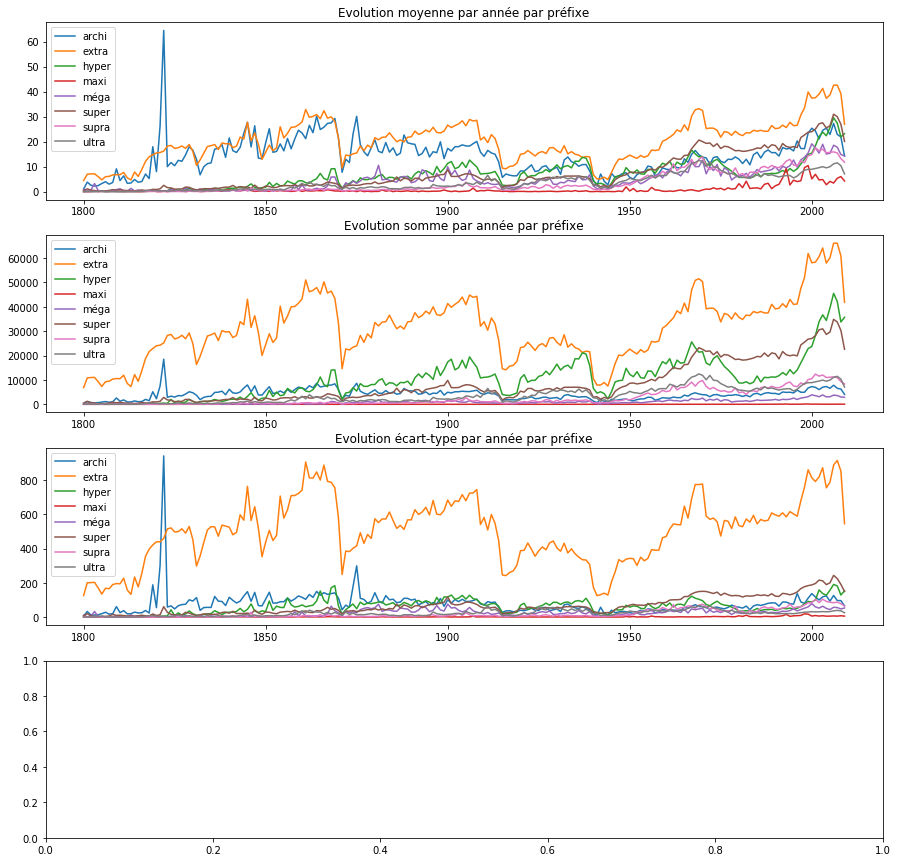

In [100]:
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
%matplotlib inline

df4 = pd.concat([df,df2,df3],ignore_index=True)
print(df4.info())
print(df4.prefix.value_counts())
synth['allgram_after_stoplist']= df4.shape[0]

#print(df4.describe())
df4.to_csv("../data/df_prefixes_allgrams.2012.after_stoplist.csv", index=False)

print(synth)

# timeline of prefixes
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, ncols=1, figsize=(15,15))
periods = [elt for elt in df4.columns if re.match("[0-9]{4}", elt)]
for k, grp in df4.groupby(['prefix']):
    grp[periods].mean().plot(legend=True,label=k, ax=ax1, title="Evolution moyenne par année par préfixe")
    grp[periods].sum().plot(legend=True,label=k, ax=ax2, title="Evolution somme par année par préfixe")
    grp[periods].std().plot(legend=True,label=k, ax=ax3, title="Evolution écart-type par année par préfixe")
    #grp[periods].count().plot(legend=True,label=k, ax=ax4, title="Evolution nbre lexies par année par préfixe")


# E. Generate Dataframe with Relative Frequency

In [101]:
def load_total_counts(corpus_id, start_year, end_year):
    '''
    This function loads the total counts for a given corpus from Google's source data.
    '''
    # map from id to url
    id_to_url= {
    15: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-all-totalcounts-20120701.txt',
    17: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-us-all-totalcounts-20120701.txt',
    18: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-gb-all-totalcounts-20120701.txt',
    16: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-fiction-all-totalcounts-20120701.txt',
    23: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-chi-sim-all-totalcounts-20120701.txt',
    19: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-fre-all-totalcounts-20120701.txt',
    20: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-ger-all-totalcounts-20120701.txt',
    24: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-heb-all-totalcounts-20120701.txt',
    22: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-ita-all-totalcounts-20120701.txt',
    25: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-rus-all-totalcounts-20120701.txt',
    21: 'http://storage.googleapis.com/books/ngrams/books/googlebooks-spa-all-totalcounts-20120701.txt'
    }
    hdr='Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv:10.0) Gecko/20100101 Firefox/10.0'
    headers={'User-Agent':hdr}
    resp = requests.get(id_to_url[corpus_id],headers=headers)
    resp.raise_for_status()
    response = resp.text
    #print(response)
    #response = urllib2.urlopen(urllib2.Request(id_to_url[corpus_id]))
    #total_counts = []
    total_counts2 = {}
    data = response.split("\t")
    for row in data:
        #print (row)
        #continue
        # first and last rows are empty, so a try...except is needed
        try:
            year, word_count, _, _ = row.split(',')
            #print(start_year)
            #print(end_year)
            #print(year)
            if int(year) >= start_year and int(year) <= end_year:
                #print(year)
                #print(word_count)
                #total_counts.append(int(word_count))
                total_counts2[year]=int(word_count)
                #print(total_counts)
        except ValueError:
            pass
        
    return total_counts2

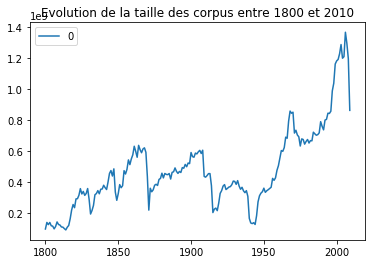

In [102]:


# load totals of tokens per corpus year
totals = load_total_counts(19,1800,2009)
pd.DataFrame.from_dict(totals, orient='index').plot(title="Evolution de la taille des corpus entre 1800 et 2010")
#pdf0.savefig()
#plt.close()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6427 entries, 0 to 6426
Columns: 215 entries, string to 2009
dtypes: float64(211), object(4)
memory usage: 10.5+ MB
None


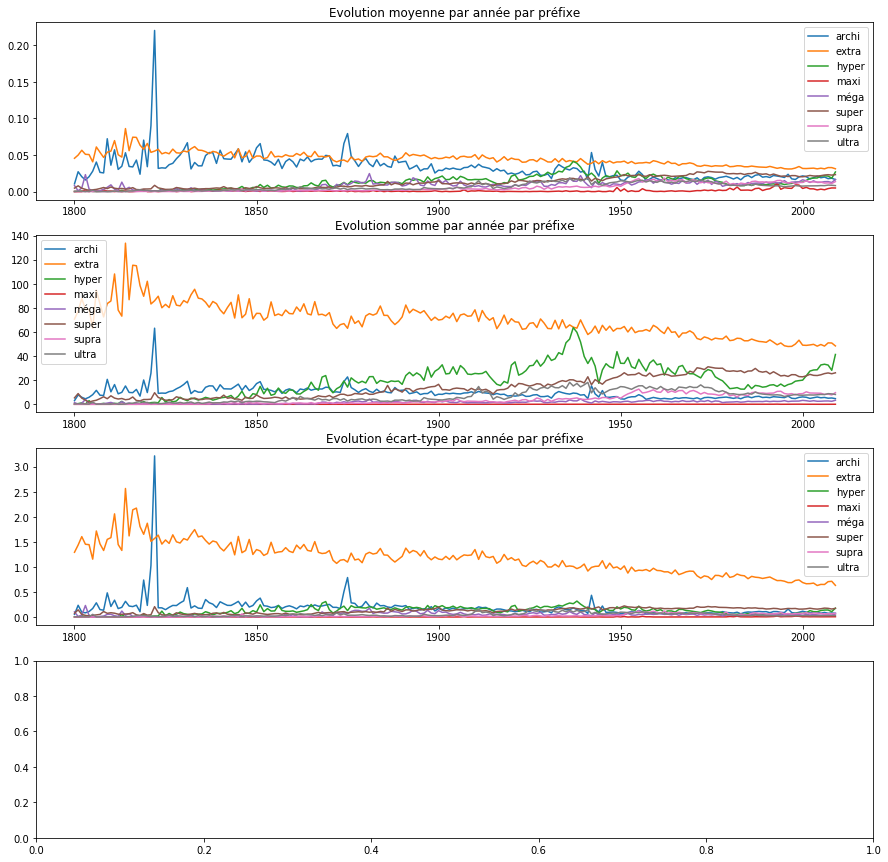

In [135]:
# generate df_rel dataframe (relative frequency = (absolute frequency / total frequency for year) * 100000)
df_rel = df4.copy(deep=True)

# load totals of tokens per corpus year
totals = load_total_counts(19,1800,2009)

# calculate relative frequency for each column

for i in range(1800,2010):
    df_rel[str(i) + '_freqrel'] = (df_rel[str(i)] / totals[str(i)]) * 1000000

# remove absolute frequency for df (relative frequency used for clustering and plotting)
df_rel = df_rel.drop([str(i) for i in range(1800,2010)], axis=1)
df_rel.columns = df_rel.columns.str.replace('_freqrel', '')

print(df_rel.info())
df_rel.to_csv("../data/df_googlengrams_all_freqrel.2012.csv", index=False)

# timeline of prefixes
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, ncols=1, figsize=(15,15))
periods = [elt for elt in df_rel.columns if re.match("[0-9]{4}", elt)]
#print(periods)
for k, grp in df_rel.groupby(['prefix']):
    grp[periods].mean().plot(legend=True,label=k, ax=ax1, title="Evolution moyenne par année par préfixe")
    grp[periods].sum().plot(legend=True,label=k, ax=ax2, title="Evolution somme par année par préfixe")
    grp[periods].std().plot(legend=True,label=k, ax=ax3, title="Evolution écart-type par année par préfixe")
    #grp[periods].agg(len).plot(legend=True,label=k, ax=ax4, title="Evolution nombre lexies par année par préfixe")
    #print(k, grp[['1800','1850','1900']].count())



         full_count         1800         1801         1802         1803  \
count  6.427000e+03  6156.000000  6156.000000  6396.000000  6334.000000   
mean   1.974855e+03     0.013165     0.015496     0.015804     0.014475   
std    5.226748e+04     0.650197     0.726240     0.791336     0.720527   
min    3.500000e+01     0.000000     0.000000     0.000000     0.000000   
25%    8.000000e+01     0.000000     0.000000     0.000000     0.000000   
50%    1.500000e+02     0.000000     0.000000     0.000000     0.000000   
75%    4.230000e+02     0.000000     0.000000     0.000000     0.000000   
max    3.794287e+06    45.021223    51.062336    55.737013    50.247243   

              1804         1805         1806         1807         1808  ...  \
count  6396.000000  6156.000000  5844.000000  6336.000000  6150.000000  ...   
mean      0.014075     0.012368     0.018803     0.015201     0.014268  ...   
std       0.712391     0.581762     0.887484     0.724031     0.669604  ...   
min     

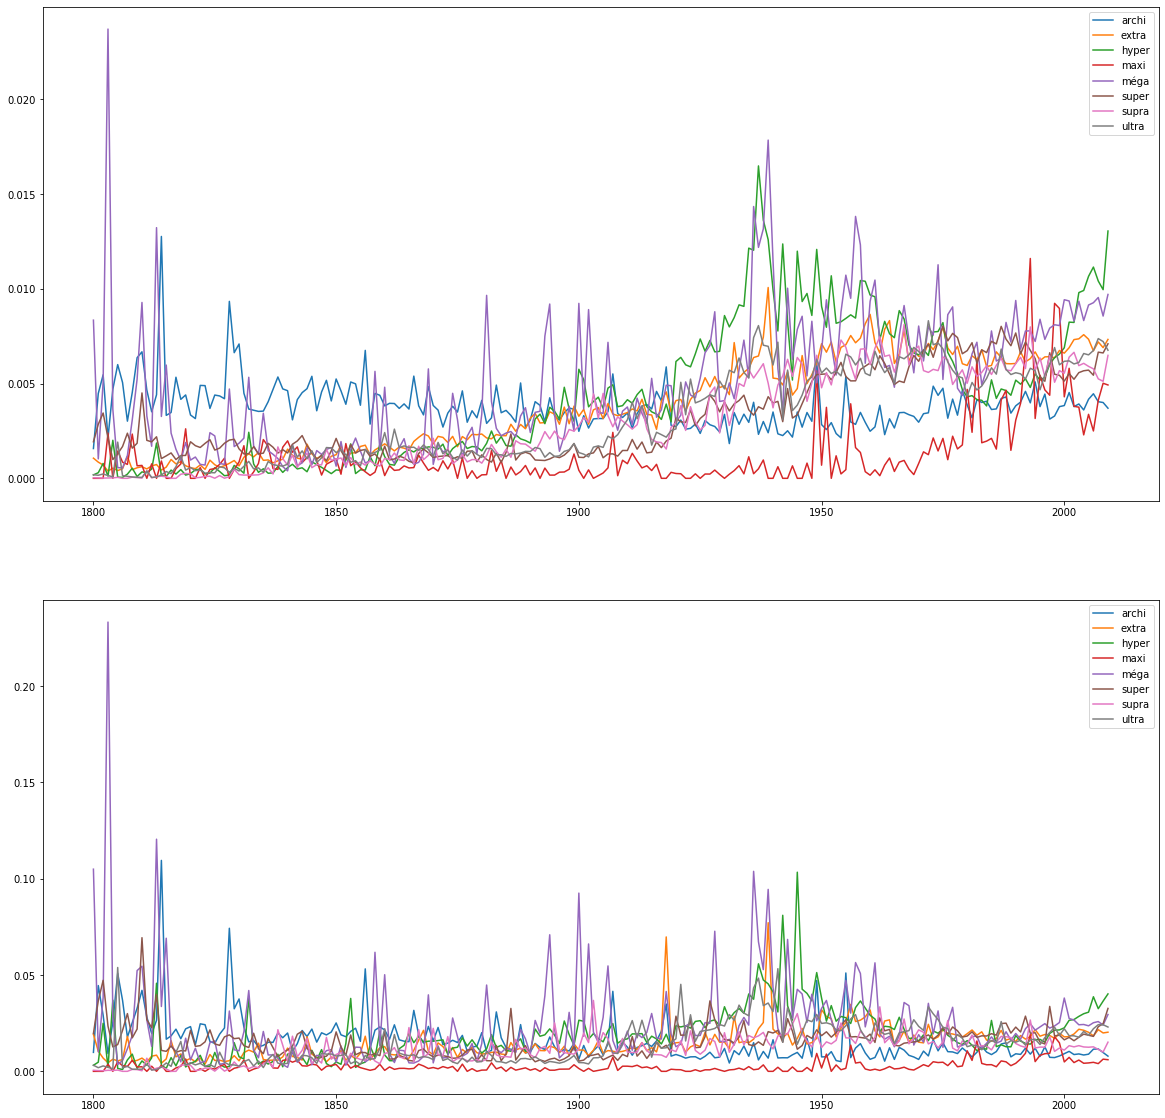

In [136]:
# without outliers

print(df_rel.describe())

df_rel2 = df_rel[df_rel.full_count < df_rel.full_count.quantile(0.975)]
df_rel3 = df_rel[df_rel.full_count > df_rel.full_count.quantile(0.975)]
df_rel3.to_csv("../data/stoplists/df_googlengrams_all_freqrel.2012.outliers.csv", index=False, columns=['string'])

print(df_rel2.info())
df_rel2.to_csv("../data/df_googlengrams_all_freqrel.2012.no_outliers.csv", index=False)

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,20))
periods = [elt for elt in df_rel2.columns if re.match("[0-9]{4}", elt)]
for k, grp in df_rel2.groupby(['prefix']):
    grp[periods].mean().plot(legend=True,label=k, ax=ax1)
    grp[periods].std().plot(legend=True,label=k, ax=ax2)


In [137]:
# for visualization in néoveille
print(df_rel.columns)
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df5 =  df_rel.copy(deep=True)
df5tmp = df5[periods]
df5tmp2 = df5[['string','prefix','word','sep']]
#print(df5tmp.info())
#print(df5tmp2.info())

df6 = df5tmp.merge(df5tmp2, right_index = True, left_index = True)
#print(df6.head())
df7 = df6.melt(id_vars = ['string','prefix','word','sep'], value_name = "rel_freq").dropna()
df7.rename(index=str, columns={"variable": "year"}, inplace=True)
df7 = df7[df7.rel_freq > 0]
print(df7.info())
print(df7.head())
df7.to_csv("../data/df_googlengrams_neoveille.2012.csv", index=False)

Index(['string', 'prefix', 'word', 'sep', 'full_count', '1800', '1801', '1802',
       '1803', '1804',
       ...
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009'],
      dtype='object', length=215)
<class 'pandas.core.frame.DataFrame'>
Index: 343104 entries, 19 to 1349660
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   string    343104 non-null  object 
 1   prefix    343104 non-null  object 
 2   word      343104 non-null  object 
 3   sep       343104 non-null  object 
 4   year      343104 non-null  object 
 5   rel_freq  343104 non-null  float64
dtypes: float64(1), object(5)
memory usage: 18.3+ MB
None
             string prefix        word     sep  year  rel_freq
19  archichancelier  archi  chancelier  FUSION  1800  0.010305
27      archicomble  archi      comble  FUSION  1800  0.020609
31   archiconfrérie  archi   confrérie  FUSION  1800  0.030914
46      archidiacre 

In [113]:
# for visualization in néoveille (no outliers)
print(df_rel2.columns)
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df5 =  df_rel2.copy(deep=True)
df5tmp = df5[periods]
df5tmp2 = df5[['string','prefix','word','sep']]
#print(df5tmp.info())
#print(df5tmp2.info())

df6 = df5tmp.merge(df5tmp2, right_index = True, left_index = True)
#print(df6.head())
df7 = df6.melt(id_vars = ['string','prefix','word','sep'], value_name = "rel_freq").dropna()
df7.rename(index=str, columns={"variable": "year"}, inplace=True)
df7 = df7[df7.rel_freq > 0]
print(df7.info())
print(df7.head())
df7.to_csv("../data/df_googlengrams_neoveille.2012.no_outliers.csv", index=False)


Index(['string', 'prefix', 'word', 'sep', 'full_count', '1800', '1801', '1802',
       '1803', '1804',
       ...
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009'],
      dtype='object', length=215)
<class 'pandas.core.frame.DataFrame'>
Index: 319849 entries, 26 to 1315850
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   string    319849 non-null  object 
 1   prefix    319849 non-null  object 
 2   word      319849 non-null  object 
 3   sep       319849 non-null  object 
 4   year      319849 non-null  object 
 5   rel_freq  319849 non-null  float64
dtypes: float64(1), object(5)
memory usage: 17.1+ MB
None
            string prefix       word     sep  year  rel_freq
26     archicomble  archi     comble  FUSION  1800  0.002061
50      archiducal  archi      ducal  FUSION  1800  0.001030
51     archiducale  archi     ducale  FUSION  1800  0.002061
54  archiduchesses  archi  d

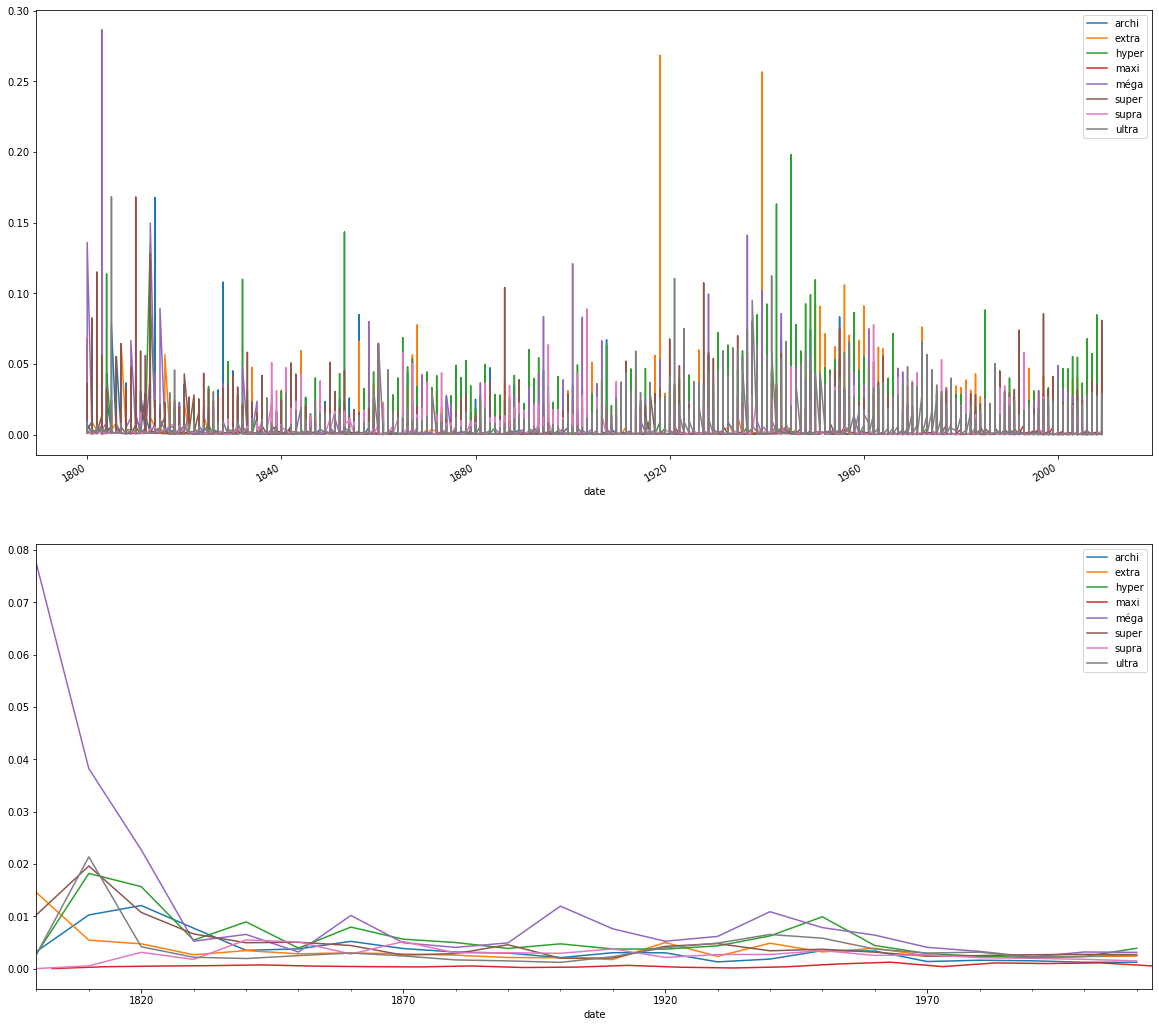

In [133]:


# visualization of timeseries by prefix
df8 =  df7.copy(deep=True)
df8['date'] = pd.to_datetime(df8['year'])
df8.set_index(df8['date'], inplace=True)
#df8.head()
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,20))
for k, grp in df8.groupby(['prefix']):
    #print(grp['rel_freq'])
    grp['rel_freq'].plot(kind="line", legend=True,label=k, ax=ax1)
    grp.resample('10Y').std()['rel_freq'].plot(kind="line", legend=True,label=k, ax=ax2)
    #grp['rel_freq'].std().plot(legend=True,label=k, ax=ax2)
    


In [114]:
### save report in excel file
def save_report(df, key, outfile):
    """
    Save report to Excel file (one sheet per prefix)
    """
    cols = sorted(list(df.columns.values),reverse=True)
    #print(cols)
    #print(df.prefix.values)
    # check all lines are filled
    is_NaN = df.prefix.isnull()
    rows_with_NaN = df[is_NaN]
    print(rows_with_NaN)

    writer = pd.ExcelWriter(outfile)
    for pref in df.prefix.unique():
        #print(pref)
        dfprint = df[df.prefix == pref].groupby(['word','string','sep'])['full_count'].sum().reset_index().sort_values('full_count', ascending=False).set_index(['word'])
        #print(dfprint)
        dfprint.to_excel(writer,pref)
        #grp.sort_values('full_count', ascending=False).set_index(['string','word','sep'])['full_count'].to_excel(writer,k)
    writer.save()
    return True


# save to excel
save_report(df4,'prefix','../data/googlengrams.fre.2012.synthesis.xls')

Empty DataFrame
Columns: [string, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, ...]
Index: []

[0 rows x 215 columns]


True

# F. Generate synthesis on data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6427 entries, 0 to 6426
Columns: 215 entries, string to 2009
dtypes: float64(211), object(4)
memory usage: 10.5+ MB
None


TypeError: '(slice(None, None, None), 0)' is an invalid key

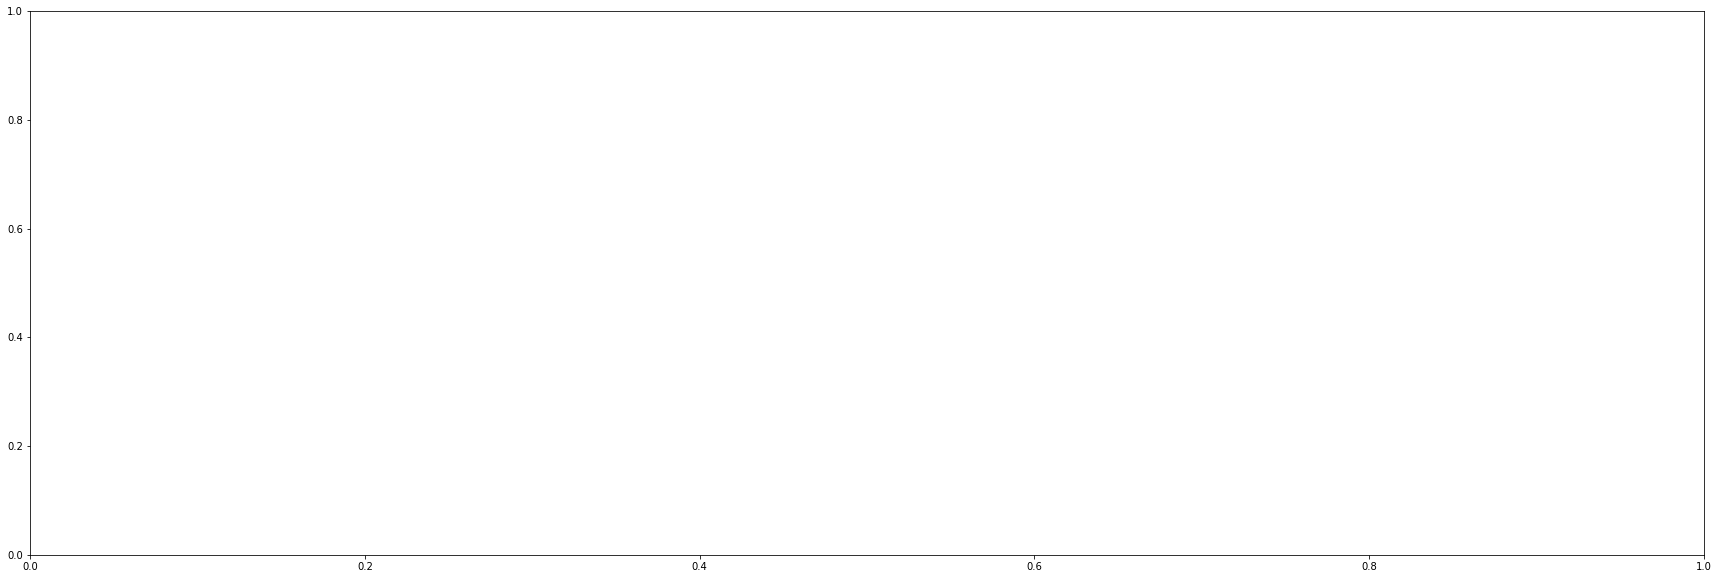

In [134]:
## VNC clustering 
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

pdf2 = PdfPages('../visu/' + corpus+ '.2012.prefix.all.HAC.pdf')

periods = [elt for elt in df_rel.columns if re.match("[0-9]{4}", elt)]

df_rel.fillna(0, inplace=True)
print(df_rel.info())
#print(periods)
for k, grp in df_rel.groupby(['prefix']):
    #print(grp[periods])
    data_scaled = normalize(grp[periods])
    data_scaled = pd.DataFrame(data_scaled, columns=periods)
    fig, ax = plt.subplots(1, figsize=(30, 10))
    plt.title("Dendrograms for " + k)  
    dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
    plt.axhline(y=6, color='r', linestyle='--')
    
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    fig.tight_layout()
    pdf2.savefig()
    plt.close()

    cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
    cluster.fit_predict(data_scaled)
    fig, ax = plt.subplots(1, figsize=(30, 10))
    plt.scatter(data_scaled[:,0], data_scaled[:,1], c=cluster.labels_) 
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    fig.tight_layout()
    pdf2.savefig()
    plt.close()
pdf2.close()

In [50]:
import requests
import sys, csv,re, random, glob,os
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import matplotlib
import seaborn as sns                            # more plots
from sklearn.metrics import mean_absolute_error
from matplotlib.backends.backend_pdf import PdfPages

In [51]:
def plot_rolling_simple(df,title, window=10):
    fig, ax = plt.subplots(2,figsize=(20, 10))
    ax[0].plot(df.index, df.data, label='raw data')
    ax[0].plot(df.data.rolling(window=window).mean(),label="rolling mean (window=" + str(window) + ")")
    ax[0].plot(df.data.rolling(window=window).std(), label="rolling std (window=" + str(window) + ")")
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=window).mean(), label="rolling mean (window=" + str(window) + ")")
    ax[1].plot(df.z_data.rolling(window=window).std(), label="rolling std (window=" + str(window) + ")")
    ax[1].legend()

    fig.suptitle(title, fontsize=13)
    plt.tight_layout()
    #fig.autofmt_xdate()
    
# useful for annotating barcharts
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


            
            
# save dataframe df
# save to excel
def save_report(df, key, outfile):
    """
    Take a report and save it to a single Excel file
    """
    cols = sorted(list(df.columns.values),reverse=True)
    #print(cols)
    writer = pd.ExcelWriter(outfile)
    #for k, grp in df[['prefix','word','full_count','string']].groupby(key):
    for pref in df.prefix.values:
        dfprint = df[df.prefix == pref].groupby(['word','string','sep'])['full_count'].sum().reset_index().sort_values('full_count', ascending=False).set_index(['word'])
        #print(dfprint)
        dfprint.to_excel(writer,pref)
        #grp.sort_values('full_count', ascending=False).set_index(['string','word','sep'])['full_count'].to_excel(writer,k)
    writer.save()
    return True


        count        sum  freq100      prod
prefix                                     
extra    3082  7668341.0   1149.0  0.372810
super    2361  2116941.0   1239.0  0.524778
ultra    1887  1235549.0    909.0  0.481717
hyper    1878  2201866.0    693.0  0.369010
supra    1318   741557.0    531.0  0.402883
archi     775  1103731.0    326.0  0.420645
méga      267   241625.0     87.0  0.325843
maxi      234   134903.0    108.0  0.461538


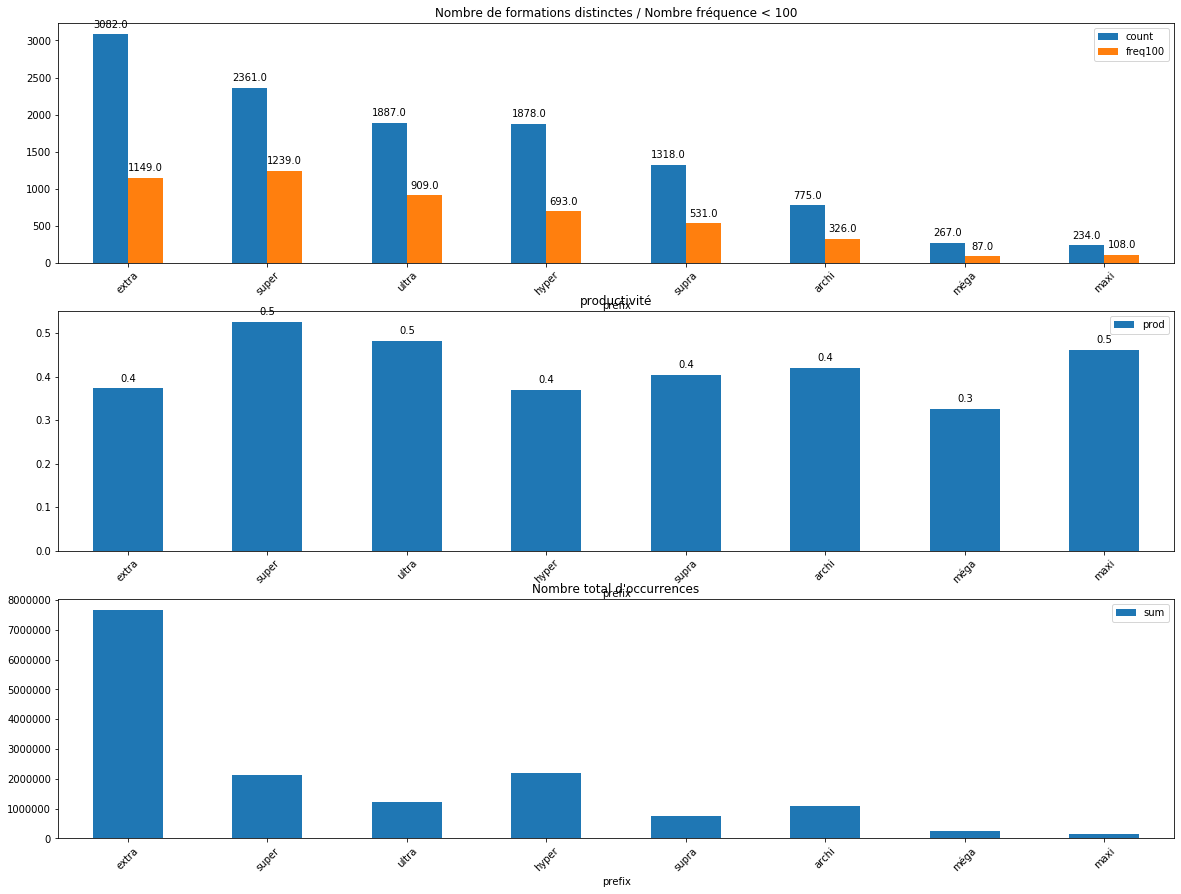

In [52]:
# calcul productivité
def freq100(x):
    #print(x)
    return len(x[x<100])
df2 = df.groupby(['prefix'])['full_count'].agg(['count','sum',freq100]).sort_values('count', ascending=False)

df2['prod'] = df2['freq100'] / df2['count']
print(df2)
fig, ax = plt.subplots(3, figsize=(20, 15))
df2[['count','freq100']].plot(kind="bar", ax=ax[0], rot=45, title="Nombre de formations distinctes / Nombre fréquence < 100",legend=True)
add_value_labels(ax[0])
df2[['prod']].plot(kind="bar",ax=ax[1], rot=45, title="productivité")

df2[['sum']].plot(kind="bar",ax=ax[2], rot=45, title="Nombre total d'occurrences")
add_value_labels(ax[1])


In [53]:
# base for browsing words
words = df.groupby('word')['full_count'].agg(['count','sum']).sort_values('sum', ascending=False)
print(words.head())
words20 = list(words.index.values)[0:20]
print(list(words.index.values)[0:20])

               count        sum
word                           
ordinaire          5  3807225.0
ordinaires         5  1657407.0
trophie            5   361346.0
position           9   353587.0
ordinairement      5   352238.0
['ordinaire', 'ordinaires', 'trophie', 'position', 'ordinairement', 'tension', 'structure', 'ficiellement', 'diacre', 'violets', 'posent', 'duchesse', 'ducs', 'marchés', 'violet', 'sensible', 'phosphate', 'nationale', 'tectonique', 'marché']


        count        sum           std
prefix                                
extra    3082  7668341.0  74809.639938
super    2361  2116941.0   9128.568276
ultra    1887  1235549.0   2846.396034
hyper    1878  2201866.0  10035.251919
supra    1318   741557.0   2482.241851
archi     775  1103731.0   8529.755639
méga      267   241625.0   3666.202539
maxi      234   134903.0   2673.780175
['extra' 'super' 'ultra' 'hyper' 'supra' 'archi' 'méga' 'maxi']
extra
word        abdominale  africaine  africaines  africains  agricole
1800-12-31    0.000000        0.0         0.0        0.0       0.0
1805-12-31    0.000849        0.0         0.0        0.0       0.0
1810-12-31    0.000000        0.0         0.0        0.0       0.0
1815-12-31    0.000000        0.0         0.0        0.0       0.0
1820-12-31    0.000911        0.0         0.0        0.0       0.0
word        abdominale  africaine  africaines  africains  agricole
1800-12-31         NaN        NaN         NaN        NaN       NaN
1805

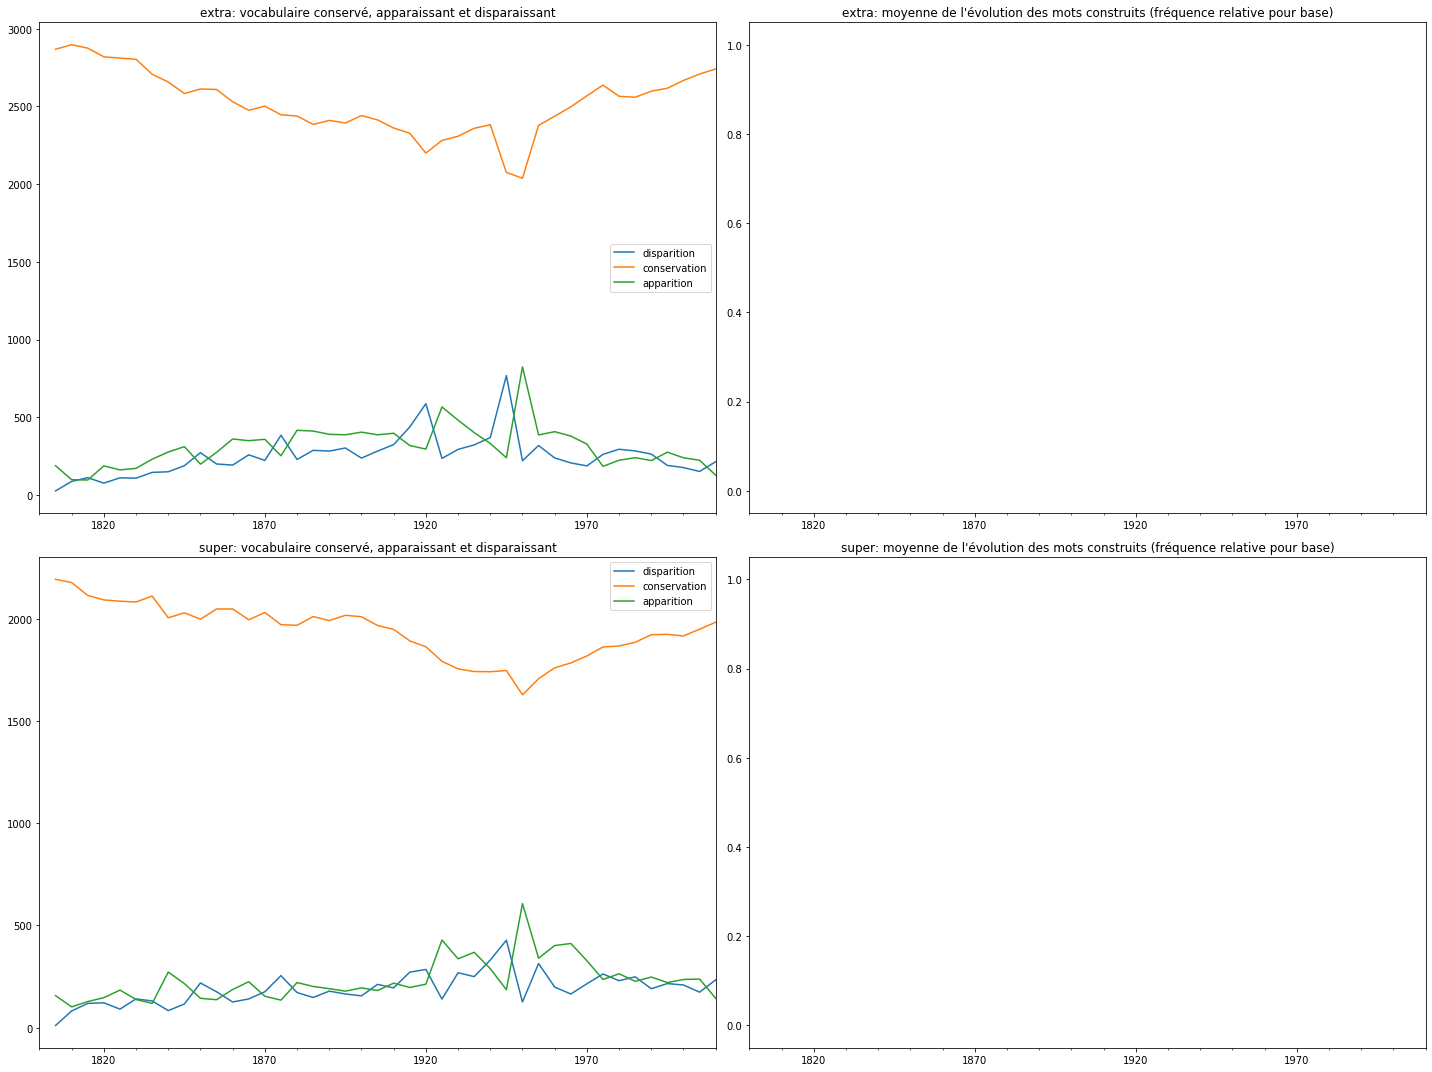

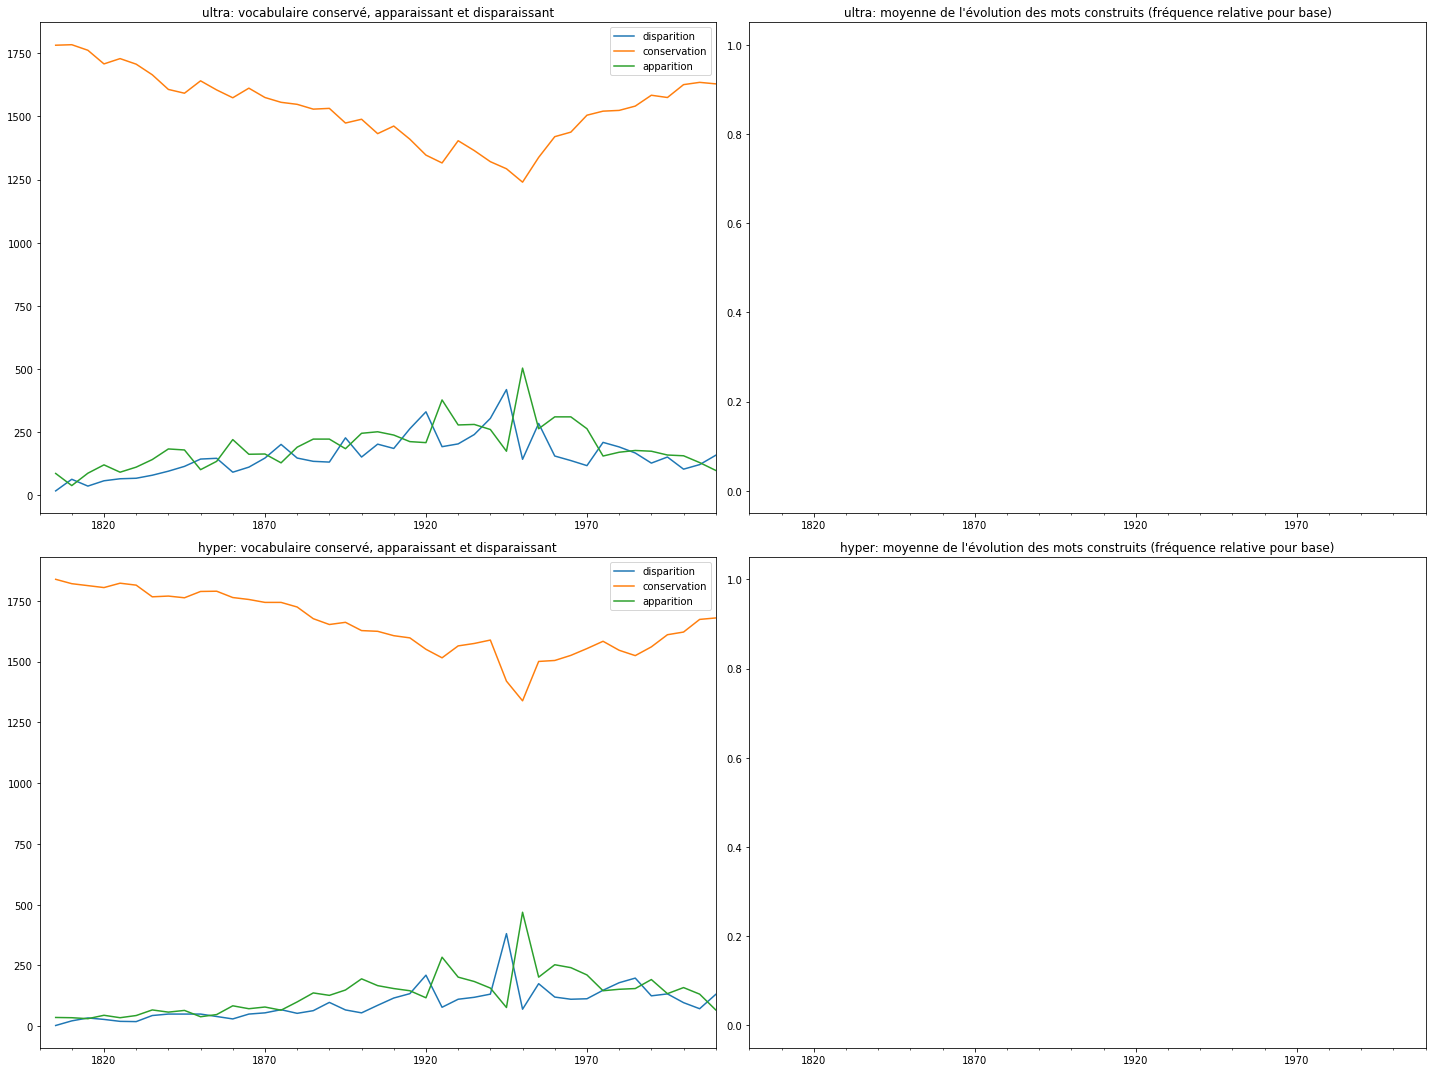

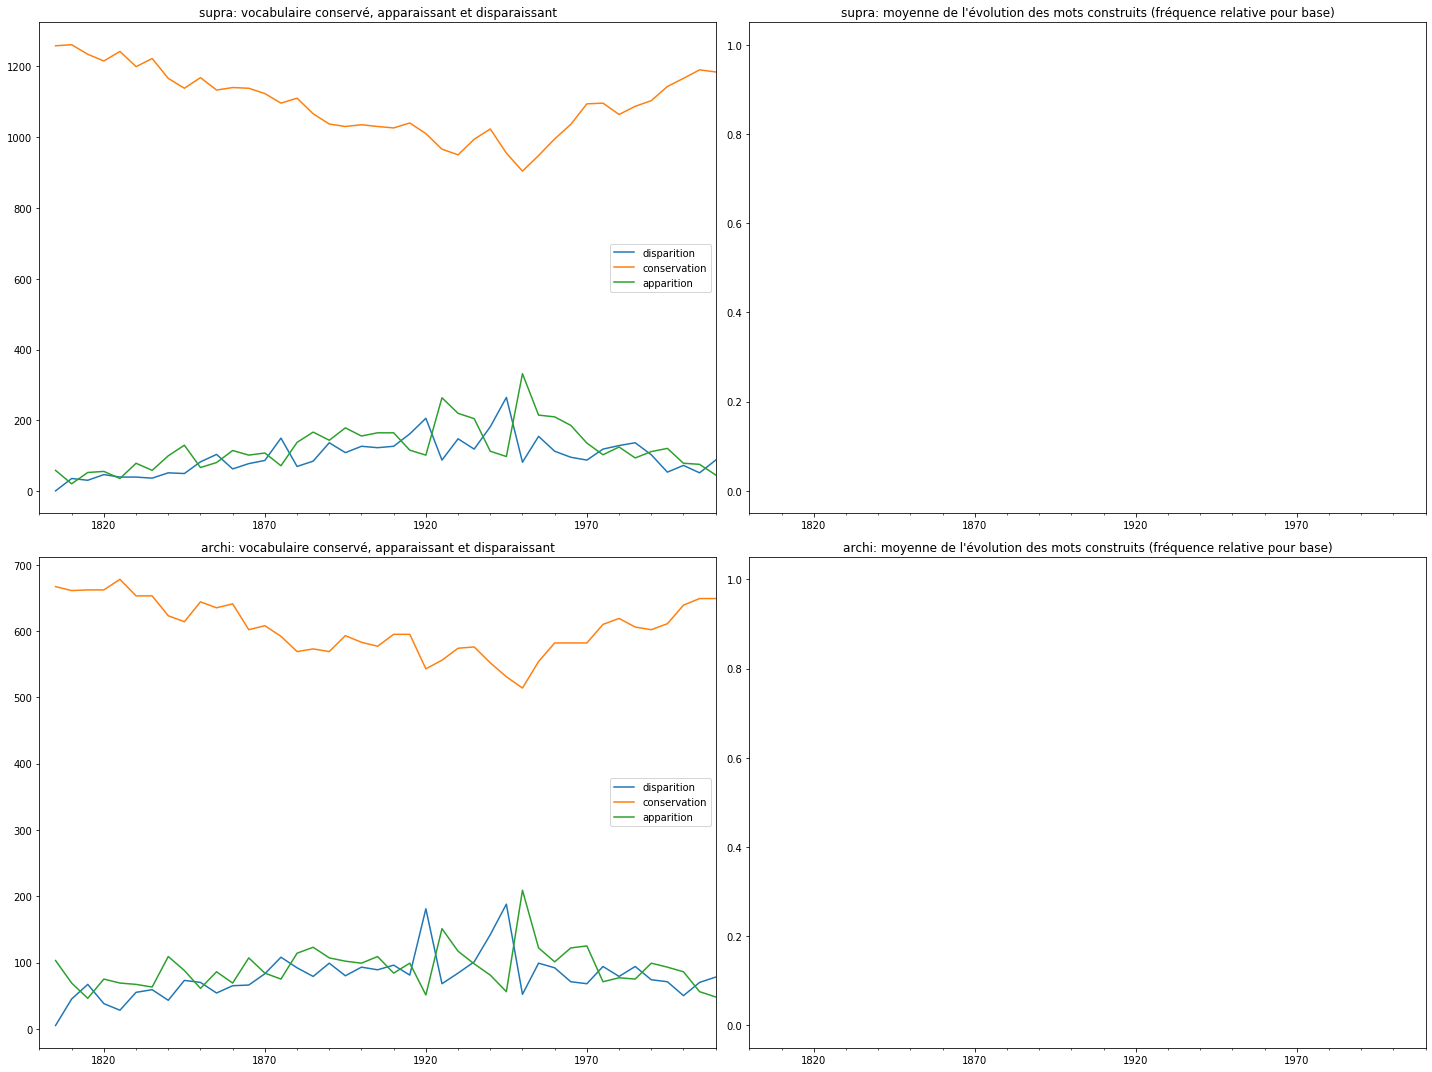

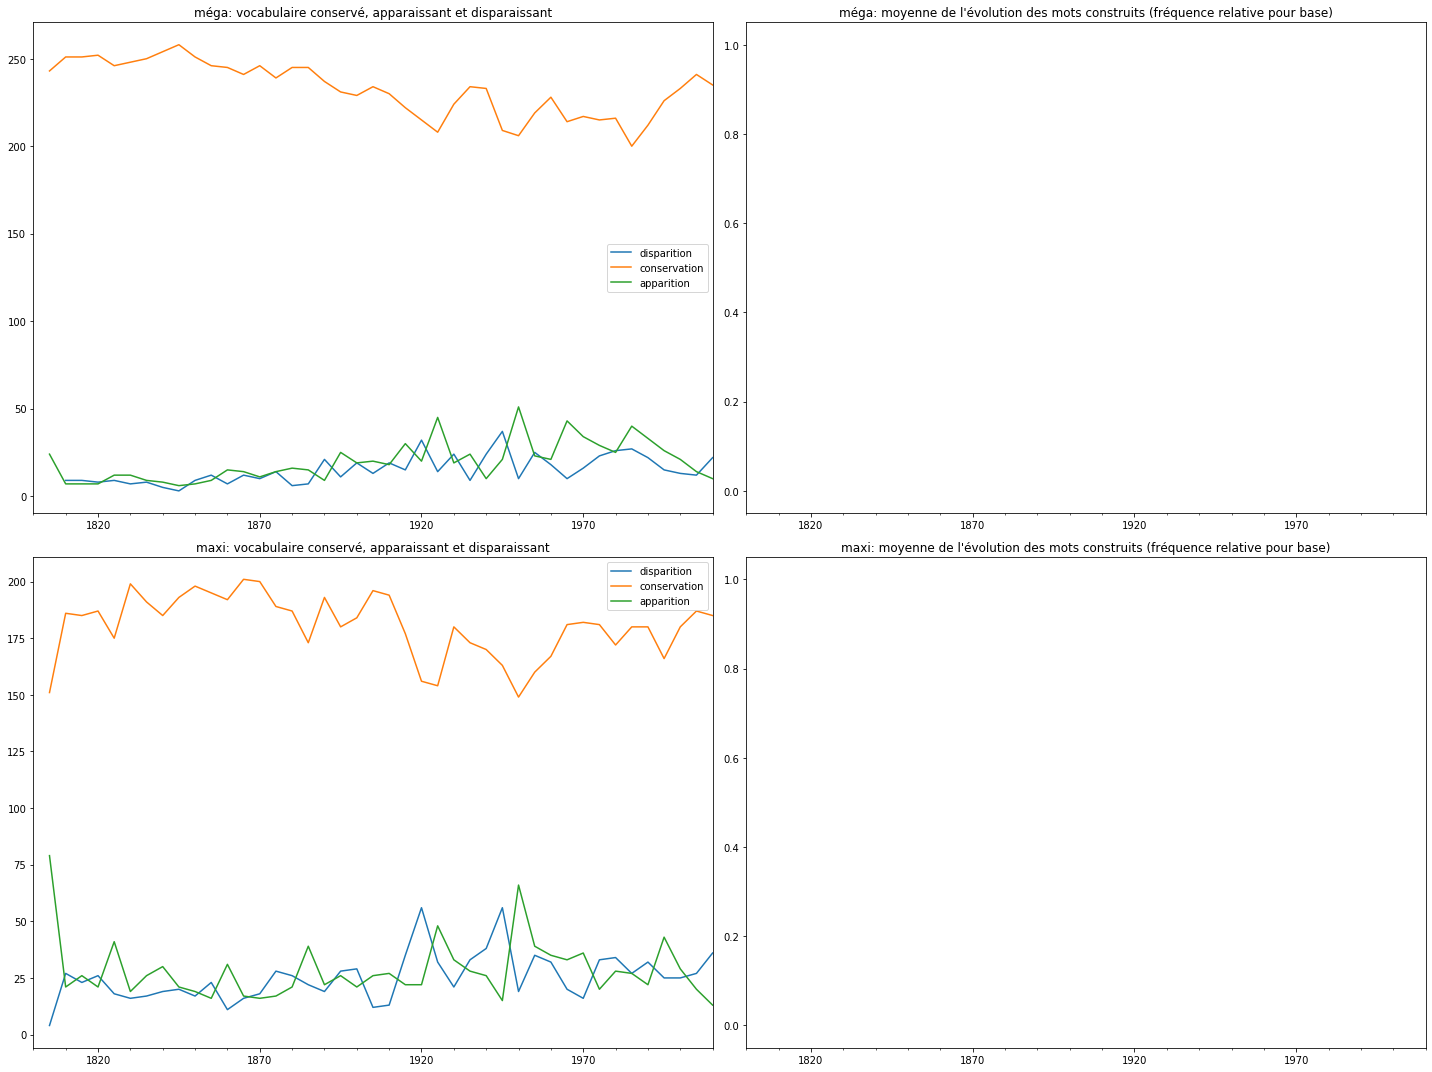

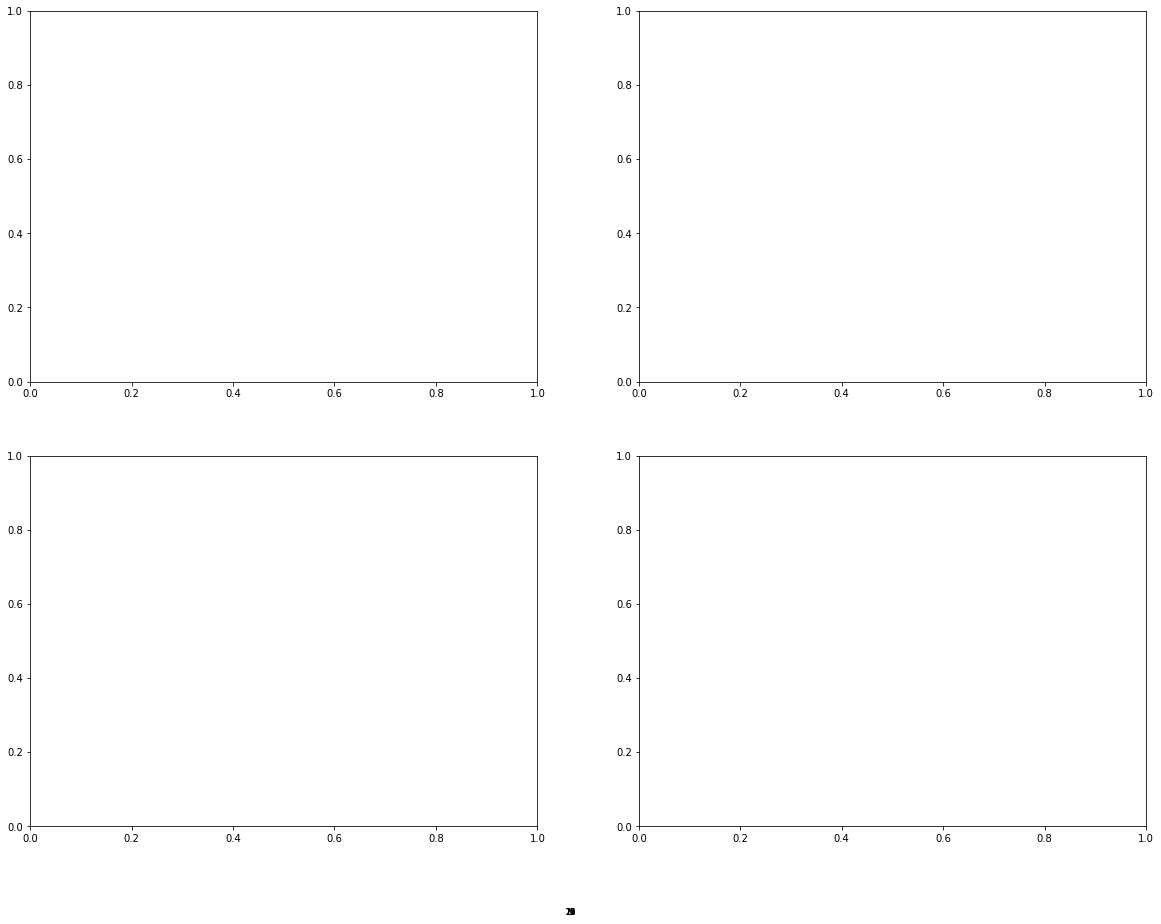

In [54]:
corpus = "googlengrams"
pdf2 = PdfPages('../visu/' + corpus+ '.2012.prefix.all.synthesis.pdf')

# base for browsing prefixes
dist1 = df.groupby('prefix')['full_count'].agg(['count','sum','std']).sort_values('count', ascending=False)
print(dist1)
print(dist1.index.values)

#columns = df.columns
#periods = [elt for elt in columns if re.match("[0-9]{4}-[0-9]{2}-[0-9]{2}", elt)]

# distribution entre les prefixes
fig, ax = plt.subplots(2, figsize=(20, 15))
df.groupby('prefix')['full_count'].count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre préfixes (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
add_value_labels(ax[0])
df.groupby('prefix')['full_count'].sum().plot(ax=ax[1],kind="bar",title="Distribution des fréquences entre préfixes (nbre total d'occurrences)", rot=45, figsize=(20,10))  # [['full_count']]
add_value_labels(ax[1])
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
fig.tight_layout()

pdf2.savefig()
plt.close()

# distribution entre les mots
fig, ax = plt.subplots(2, figsize=(20, 15))
#df.groupby('source')['full_count'].nlargest(20).count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre sources (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
df[df.word.isin(words20)].groupby('word')['full_count'].count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre mots (20) (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
add_value_labels(ax[0])
df[df.word.isin(words20)].groupby('word')['full_count'].sum().plot(ax=ax[1],kind="bar",title="Distribution des fréquences entre mots (20) (nbre total d'occurrences)", rot=45, figsize=(20,10))  # [['full_count']]
add_value_labels(ax[1])
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
fig.tight_layout()

pdf2.savefig()
plt.close()

# distribution entre les séparateurs
fig, ax = plt.subplots(2, figsize=(20, 15))
df.groupby('sep')['full_count'].count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre séparateurs  (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
add_value_labels(ax[0])
df.groupby('sep')['full_count'].sum().plot(ax=ax[1],kind="bar",title="Distribution des fréquences entre séparateurs  (nbre total d'occurrences)", rot=45, figsize=(20,10))  # [['full_count']]
add_value_labels(ax[1])
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
fig.tight_layout()

pdf2.savefig()
plt.close()



   
# distribution plots
fig, ax = plt.subplots(8,3, figsize=(20, 15))
# get 0.9 quantile
i = 0
for pref in dist1.index.values:
        dfplot = df[df.prefix == pref]
        sns.distplot(dfplot['full_count'], ax=ax[i][0]).set_title('{} : {} formes distinctes, {} total occurrences (100%)'.format(pref, dist1.loc[pref,'count'], dist1.loc[pref,'sum']))
        # get 0.95 quantile
        q = dfplot["full_count"].quantile(0.9)
        dfplot2 = dfplot[dfplot["full_count"] < q]['full_count']      
        sns.distplot(dfplot2, ax=ax[i][1]).set_title(pref + ' : 90% quantiles')
        #sns.distplot(np.log(dfplot), ax=ax[0])
        sns.boxplot(dfplot2,ax=ax[i][2]).set_title(pref + ' : 90% quantiles')
        i=i+1
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
fig.tight_layout()
pdf2.savefig()
plt.close()         

q = df["full_count"].quantile(0.9)
dfplot2 = df[df["full_count"] < q]      

sns.boxplot(x="prefix", y="full_count", data=dfplot2).set_title("Boîte à moustache des préfixes (fréquences absolues, 90% quantile)")
    # +  (TBD) kind= violin, box, boxen...
pdf2.savefig()
plt.close()


# evolution globale pour chaque préfixe
dfplot = df.groupby('prefix')[periods].sum().T
dfplot.index = pd.to_datetime(dfplot.index)
dfplot_rel = df_rel.groupby('prefix')[periods].sum().T
# freq absolue
fig, ax = plt.subplots(1, figsize=(20, 15))
dfplot.plot(ax=ax,kind="line", title="Evolution des distributions des préfixes (fréquence absolue, périodisation originelle)", rot=45, figsize=(20,10))  # [['full_count']]    
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
pdf2.savefig()
plt.close()


# freq rel
fig, ax = plt.subplots(1, figsize=(20, 15))
dfplot_rel.plot(ax=ax,kind="line", title="Evolution des distributions des préfixes (fréquence relative)", rot=45, figsize=(20,10))  # [['full_count']]    
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
pdf2.savefig()
plt.close()


# freq rel
fig, ax = plt.subplots(1, figsize=(20, 15))
dfplot_rel.ewm(span = 10).mean().plot(ax=ax,kind="line", title="Evolution des distributions des préfixes (fréquence relative), Lissage 10 ans", rot=45, figsize=(20,10))  # [['full_count']]    
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
pdf2.savefig()
plt.close()



# evolution nbre de mots distincts
fig, ax = plt.subplots(1, figsize=(20, 15))
for k,grp in df_rel.groupby(['prefix']):
    grp[periods].astype(bool).sum(axis=0).T.plot(legend=True, ax=ax,kind="line", title="Evolution du nombre de formes différentes", rot=45, figsize=(20,10))  # [['full_count']]
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
pdf2.savefig()
plt.close()


# evolution globale pour chaque mots
fig, ax = plt.subplots(1, figsize=(20, 15))
dfplot = df[df.word.isin(words20)].groupby('word')[periods].sum().T
dfplot.index = pd.to_datetime(dfplot.index)
dfplot_rel = df_rel[df_rel.word.isin(words20)].groupby('word')[periods].sum().T
dfplot4=dfplot.resample('5A').sum()
#dfplot.plot(legend=None, ax=ax[0],kind="line", title="Evolution des distributions des mots (fréquence absolue, périodisation originelle)", rot=45, figsize=(20,10))  # [['full_count']]    
#dfplot4.plot(legend=None, ax=ax[1],kind="line", title="Evolution des distributions des mots (fréquence absolue, période 5 ans)", rot=45, figsize=(20,10))  # [['full_count']]    
dfplot_rel.plot(ax=ax,kind="line", title="Evolution des distributions des mots (fréquence relative)", rot=45, figsize=(20,10))  # [['full_count']]    
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
fig.tight_layout()
pdf2.savefig()
plt.close()


# evolution globale pour chaque séparateur
fig, ax = plt.subplots(1, figsize=(20, 15))
dfplot = df.groupby('sep')[periods].sum().T
dfplot.index = pd.to_datetime(dfplot.index)
dfplot_rel = df_rel.groupby('sep')[periods].sum().T
dfplot4=dfplot.resample('5A').sum()
#dfplot.plot(legend=None, ax=ax[0],kind="line", title="Evolution des distributions des séparateurs (fréquence absolue, périodisation originelle)", rot=45, figsize=(20,10))  # [['full_count']]    
#dfplot4.plot(legend=None, ax=ax[1],kind="line", title="Evolution des distributions des séparateurs (fréquence absolue, période 5 ans)", rot=45, figsize=(20,10))  # [['full_count']]    
dfplot_rel.plot(ax=ax,kind="line", title="Evolution des distributions des séparateurs (fréquence relative)", rot=45, figsize=(20,10))  # [['full_count']]    
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
fig.tight_layout()
pdf2.savefig()
plt.close()




# get 0.9 quantile
i = 0
fig, ax = plt.subplots(2,2, figsize=(20, 15))
for pref in dist1.index.values:
    print(pref)
    dfplot3 = df_rel[df_rel.prefix == pref].set_index('word')[periods].T
    dfplot3.index = pd.to_datetime(dfplot3.index)
    dfplot4=dfplot3.resample('5y').sum()
    print(dfplot4.iloc[0:5,0:5])
    #print(np.log(dfplot4.iloc[0:5,0:5]))
    dfplotdiffres = (dfplot4/1000).apply(np.ceil).diff()
    print(dfplotdiffres.iloc[0:5,0:5])
    dfplotdiffres = dfplotdiffres.loc[:, (dfplotdiffres != 0).any(axis=0)]
    print(dfplotdiffres.iloc[0:5,0:5])
    dfdiffok = dfplotdiffres.apply(lambda x : x.value_counts(), axis=1)
    dfdiffok.rename(columns={-1.0:'disparition',
                          0.0:'conservation',
                          1.0:'apparition'}, 
                 inplace=True)
    print(dfdiffok.iloc[0:5,0:5])
    dfdiffok.plot(ax=ax[i][0], title=pref + ": vocabulaire conservé, apparaissant et disparaissant")

    dfplotdiffres['mean_diff'] = dfplot3.diff().apply(lambda x : x.mean(), axis=1)
    dfplotdiffres['mean_diff'].plot(ax=ax[i][1], title=pref + ": moyenne de l'évolution des mots construits (fréquence relative pour base)")

    if i==1:
        fig.tight_layout()
        pdf2.savefig()
        fig, ax = plt.subplots(2,2, figsize=(20, 15))
        i=0
    else:
        i=i+1
        
 




# moving average, trends etc.
df5 = df_rel.groupby('prefix').sum()[periods]
for pref in dist1.index.values : #df5.index.values:
    series = df5.loc[pref]
    #series.index = series.index.resample("W", how='sum')
    ts = pd.DataFrame({'data':series.values}, index=series.index) # 'year':seriesrel.index, 

    ts['z_data'] = (ts['data'] - ts.data.rolling(window=10).mean()) / ts.data.rolling(window=10).std()
    #ts['zp_data'] = ts['z_data'] - ts['z_data'].shift(10)
    plot_rolling_simple(ts,title= pref, window=10)
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    pdf2.savefig()
    plt.close()
pdf2.close()



In [96]:
### par préfixe

for pref in dist1.index.values:
    pdf2 = PdfPages('../visu/' + pref + '_all_noPOS_synthesis_' + corpus + '.2012.pdf')
    dfpref = df[df.prefix==pref]
    dfwpref = df_rel[df_rel.prefix==pref]
    dfpref_rel = df_rel[df_rel.prefix==pref]

    words = dfpref.groupby('word')['full_count'].agg(['count','sum']).sort_values('sum', ascending=False)
   # print(sources)
    words20pref = list(words.index.values)[0:20]
    #print(list(sources.index.values)[0:20])    

    
    # distribution 
    fig, ax = plt.subplots(2, figsize=(20, 15))
    dfpref.groupby('prefix')['full_count'].count().plot(ax=ax[0],kind="bar",title=pref + ' : distribution des fréquences (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
    add_value_labels(ax[0])
    dfpref.groupby('prefix')['full_count'].sum().plot(ax=ax[1],kind="bar",title=pref + " : distribution des fréquences (nbre total d'occurrences)", rot=45, figsize=(20,10))  # [['full_count']]
    add_value_labels(ax[1])
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    fig.tight_layout()

    pdf2.savefig()
    plt.close()

    
    
    # distribution entre les mots générés les plus fréquents d'informations
    fig, ax = plt.subplots(2, figsize=(20, 15))
    #df.groupby('source')['full_count'].nlargest(20).count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre sources (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
    dfpref[df.word.isin(words20pref)].groupby('word')['full_count'].count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre mots (20) (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
    add_value_labels(ax[0])
    dfpref[df.word.isin(words20pref)].groupby('word')['full_count'].sum().plot(ax=ax[1],kind="bar",title="Distribution des fréquences entre mots (20) (nbre total d'occurrences)", rot=45, figsize=(20,10))  # [['full_count']]
    add_value_labels(ax[1])
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    fig.tight_layout()
    
    pdf2.savefig()
    plt.close()
    
    # distribution entre les séparateurs de mots
    fig, ax = plt.subplots(2, figsize=(20, 15))
    #df.groupby('source')['full_count'].nlargest(20).count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre sources (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
    dfpref.groupby('sep')['full_count'].count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre séparateurs  (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
    add_value_labels(ax[0])
    dfpref.groupby('sep')['full_count'].sum().plot(ax=ax[1],kind="bar",title="Distribution des fréquences entre séparateurs  (nbre total d'occurrences)", rot=45, figsize=(20,10))  # [['full_count']]
    add_value_labels(ax[1])
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    fig.tight_layout()
    
    pdf2.savefig()
    plt.close()
  
    
    # distribution plots
    fig, ax = plt.subplots(3, figsize=(20, 15))
    dfplot = dfpref
    sns.distplot(dfplot['full_count'], ax=ax[0]).set_title('{} : {} formes distinctes, {} total occurrences (100%)'.format(pref, dist1.loc[pref,'count'], dist1.loc[pref,'sum']))
    # get 0.95 quantile
    q = dfplot["full_count"].quantile(0.9)
    dfplot2 = dfplot[dfplot["full_count"] < q]['full_count']      
    sns.distplot(dfplot2, ax=ax[1]).set_title(pref + ' : 90% quantiles')
    #sns.distplot(np.log(dfplot), ax=ax[0])
    sns.boxplot(dfplot2,ax=ax[2]).set_title(pref + ' : 90% quantiles')
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    fig.tight_layout()
    pdf2.savefig()
    plt.close()         
    
    
    
    # evolution globale pour chaque préfixe
    dfplot = dfpref[periods].sum().T
    dfplot.index = pd.to_datetime(dfplot.index)
    dfplot_rel = dfpref_rel[periods].sum().T
    # freq absolue
    fig, ax = plt.subplots(1, figsize=(20, 15))
    dfplot.plot(ax=ax,kind="line", title=pref + " : évolution des distributions des préfixes (fréquence absolue, périodisation originelle)", rot=45, figsize=(20,10))  # [['full_count']]    
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    pdf2.savefig()
    plt.close()
    
    
    # freq rel
    fig, ax = plt.subplots(1, figsize=(20, 15))
    dfplot_rel.plot(ax=ax,kind="line", title=pref + " : évolution des distributions des préfixes (fréquence relative)", rot=45, figsize=(20,10))  # [['full_count']]    
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    pdf2.savefig()
    plt.close()
    
    # evolution nbre de mots distincts
    fig, ax = plt.subplots(1, figsize=(20, 15))
    dfpref[periods].astype(bool).sum(axis=0).T.plot(ax=ax,kind="line", title=pref + " : évolution du nombre de formes différentes", rot=45, figsize=(20,10))  # [['full_count']]
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    pdf2.savefig()
    plt.close()
    
     # evolution globale pour chaque mot
    fig, ax = plt.subplots(1, figsize=(20, 15))
    dfplot = dfpref[dfpref.word.isin(words20pref)].groupby('word')[periods].sum().T
    dfplot.index = pd.to_datetime(dfplot.index)
    dfplot_rel = dfpref_rel[dfpref_rel.word.isin(words20pref)].groupby('word')[periods].sum().T
    dfplot4=dfplot.resample('5A').sum()
#    dfplot.plot(legend=None, ax=ax[0],kind="line", title="Evolution des distributions des mots (fréquence absolue, périodisation originelle)", rot=45, figsize=(20,10))  # [['full_count']]    
#    dfplot4.plot(legend=None, ax=ax[1],kind="line", title="Evolution des distributions des mots (fréquence absolue, période 5 ans)", rot=45, figsize=(20,10))  # [['full_count']]    
    dfplot_rel.plot(ax=ax,kind="line", title=pref + " : évolution des distributions des mots (fréquence relative)", rot=45, figsize=(20,10))  # [['full_count']]    
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    fig.tight_layout()
    pdf2.savefig()
    plt.close()
    
     # evolution globale pour chaque séparateur
    fig, ax = plt.subplots(1, figsize=(20, 15))
    dfplot = dfpref.groupby('sep')[periods].sum().T
    dfplot.index = pd.to_datetime(dfplot.index)
    dfplot_rel = dfpref_rel.groupby('sep')[periods].sum().T
    dfplot4=dfplot.resample('5A').sum()
    #dfplot.plot(legend=None, ax=ax[0],kind="line", title="Evolution des distributions des séparateurs (fréquence absolue, périodisation originelle)", rot=45, figsize=(20,10))  # [['full_count']]    
    #dfplot4.plot(legend=None, ax=ax[1],kind="line", title="Evolution des distributions des séparateurs (fréquence absolue, période 5 ans)", rot=45, figsize=(20,10))  # [['full_count']]    
    dfplot_rel.plot(ax=ax,kind="line", title=pref + " : évolution des distributions des séparateurs (fréquence relative)", rot=45, figsize=(20,10))  # [['full_count']]    
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    fig.tight_layout()
    pdf2.savefig()
    plt.close()
    
  
    
    # get 0.9 quantile
    fig, ax = plt.subplots(2, figsize=(20, 15))
    dfplot3 = dfpref_rel.set_index('word')[periods].T
    dfplot3.index = pd.to_datetime(dfplot3.index)
    dfplotdiffres = dfplot3.apply(np.ceil).diff()

    dfdiffok = dfplotdiffres.apply(lambda x : x.value_counts(), axis=1)
    dfdiffok.rename(columns={-1.0:'disparition',
                          0.0:'conservation',
                          1.0:'apparition'}, 
                 inplace=True)
    #print(dfdiffok)
    dfdiffok.plot(ax=ax[0], title=pref + ": vocabulaire conservé, apparaissant et disparaissant")

    dfplotdiffres['mean_diff'] = dfplot3.diff().apply(lambda x : x.mean(), axis=1)
    dfplotdiffres['mean_diff'].plot(ax=ax[1], title=pref + ": moyenne de l'évolution des mots construits (fréquence relative pour base)")

    fig.tight_layout()
    pdf2.savefig()
    plt.close()
    
    
    # moving average, trends etc.
    df5 = dfpref_rel.groupby('prefix').sum()[periods]
    series = df5.loc[pref]
    #series.index = series.index.resample("W", how='sum')
    ts = pd.DataFrame({'data':series.values}, index=series.index) # 'year':seriesrel.index, 

    ts['z_data'] = (ts['data'] - ts.data.rolling(window=10).mean()) / ts.data.rolling(window=10).std()
    #ts['zp_data'] = ts['z_data'] - ts['z_data'].shift(10)
    plot_rolling_simple(ts,title= pref, window=10)
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    pdf2.savefig()
    plt.close()
    
    pdf2.close()



/Users/emmanuelcartier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/emmanuelcartier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/emmanuelcartier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/emmanuelcartier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/emmanuelcartier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/emmanuelcartier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index